## LayoutLMv3 Test Notebook

Author: Jackson Guthrie.
Purpose: Classify a form-based long document into various document types using computer vision techniques.

Environment: cv-learning-dev from `environment.yml` in this repo.

In [95]:
from transformers import AutoProcessor, AutoModel
from datasets import load_dataset
import torch
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt

In [21]:
# Suppress warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [91]:
# Load a small sample of RVL-CDIP
dataset = load_dataset("rvl_cdip", split="train[:1000]", trust_remote_code=True)  # Adjust sample size as needed

# Load LayoutLMv3 processor and model
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")

In [96]:
embeddings = []
for doc in dataset:
    # Convert image to RGB if needed
    img = doc["image"]
    if img.mode != "RGB":
        img = img.convert("RGB")

    # Prepare inputs for LayoutLMv3 (text, bbox, image)
    encoding = processor(
        images=img,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    with torch.no_grad():
        outputs = model(**encoding)
        # Use [CLS] token embedding as document representation
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_emb)

embeddings = np.array(embeddings)
embeddings_std = StandardScaler().fit_transform(embeddings)

KeyboardInterrupt: 

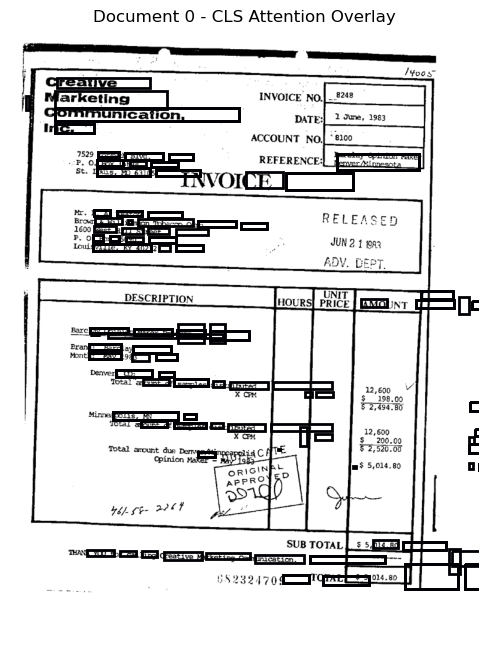

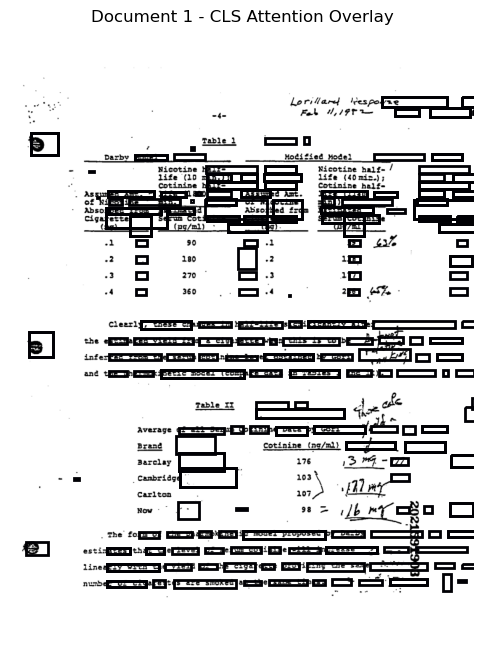

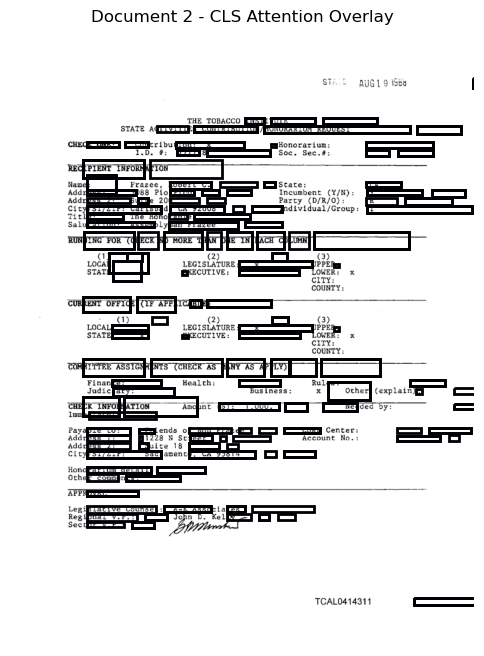

In [98]:
import matplotlib.patches as patches

for idx in range(3):
    doc = dataset[idx]
    img = doc["image"] if isinstance(doc, dict) else doc[0]
    if img.mode != "RGB":
        img = img.convert("RGB")
    encoding = processor(
        images=img,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    with torch.no_grad():
        outputs = model(**encoding, output_attentions=True)
        attn = outputs.attentions[-1][0]  # (num_heads, seq_len, seq_len)
        attn_mean = attn.mean(dim=0).cpu().numpy()  # (seq_len, seq_len)
        cls_attn = attn_mean[0]  # Attention from CLS to all tokens

    # Visualize attention on bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()
    # If you have bboxes in your encoding, use them
    if "bbox" in encoding:
        bboxes = encoding["bbox"][0].cpu().numpy()
        for i, bbox in enumerate(bboxes):
            if i == 0:  # CLS token, skip
                continue
            x0, y0, x1, y1 = bbox
            # Normalize attention for visualization
            color = plt.cm.inferno(cls_attn[i] / cls_attn.max())
            rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Document {idx} - CLS Attention Overlay")
    plt.axis('off')
    plt.show()

Let's try some PCA for dimensionality reduction

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Reduce to 50 dimensions (or try 2 for visualization)
embeddings_pca = pca.fit_transform(embeddings_std)

Okay, now let's peform clustering.

**DBScan:**

We'll start by tuning `eps` and `min_samples` in the `DBSCAN` function to find the best method for clustering.

In [77]:
best_purity = 0
best_eps = None
best_min_samples = None

for eps in np.arange(0.5, 5.1, 0.1):
    for min_samples in range(3, 21, 1):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(embeddings_pca)
        purity = cluster_purity(labels, true_labels)
        print(f"eps={eps:.2f}, min_samples={min_samples}, purity={purity:.4f}")
        if purity > best_purity:
            best_purity = purity
            best_eps = eps
            best_min_samples = min_samples

print(f"Best purity: {best_purity:.4f} at eps={best_eps}, min_samples={best_min_samples}")

eps=0.50, min_samples=3, purity=0.0710
eps=0.50, min_samples=4, purity=0.0710
eps=0.50, min_samples=5, purity=0.0710
eps=0.50, min_samples=6, purity=0.0710
eps=0.50, min_samples=7, purity=0.0710
eps=0.50, min_samples=8, purity=0.0710
eps=0.50, min_samples=9, purity=0.0710
eps=0.50, min_samples=10, purity=0.0710
eps=0.50, min_samples=11, purity=0.0710
eps=0.50, min_samples=12, purity=0.0710
eps=0.50, min_samples=13, purity=0.0710
eps=0.50, min_samples=14, purity=0.0710
eps=0.50, min_samples=15, purity=0.0710
eps=0.50, min_samples=16, purity=0.0710
eps=0.50, min_samples=17, purity=0.0710
eps=0.50, min_samples=18, purity=0.0710
eps=0.50, min_samples=19, purity=0.0710
eps=0.50, min_samples=20, purity=0.0710
eps=0.60, min_samples=3, purity=0.0710
eps=0.60, min_samples=4, purity=0.0710
eps=0.60, min_samples=5, purity=0.0710
eps=0.60, min_samples=6, purity=0.0710
eps=0.60, min_samples=7, purity=0.0710
eps=0.60, min_samples=8, purity=0.0710
eps=0.60, min_samples=9, purity=0.0710
eps=0.60, min_

In [78]:
# Run DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(embeddings_pca)

# Print cluster statistics
unique, counts = np.unique(labels, return_counts=True)
print("Cluster label counts:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Cluster label counts:
Label -1: 387 samples
Label 0: 473 samples
Label 1: 9 samples
Label 2: 27 samples
Label 3: 15 samples
Label 4: 3 samples
Label 5: 28 samples
Label 6: 6 samples
Label 7: 3 samples
Label 8: 3 samples
Label 9: 6 samples
Label 10: 4 samples
Label 11: 3 samples
Label 12: 4 samples
Label 13: 4 samples
Label 14: 3 samples
Label 15: 5 samples
Label 16: 4 samples
Label 17: 3 samples
Label 18: 4 samples
Label 19: 3 samples
Label 20: 3 samples


**Note: DBSCAN is not really that helpful for this specific task on RVL-CDIP, as there are exactly 16 resulting classes. DBSCAN cannot be forced to generate a certain number of clusters.**

In [81]:
print(f"The best purity achieved through DBSCAN was {best_purity:.4f}.")

The best purity achieved through DBSCAN was 0.1730.


KMeans:

In [86]:
from sklearn.cluster import KMeans

n_clusters = 16  # RVL-CDIP has 16 classes
kmeans = KMeans(n_clusters=n_clusters, random_state=420)
labels = kmeans.fit_predict(embeddings_pca)  # Use PCA-reduced embeddings

# Print cluster statistics
unique, counts = np.unique(labels, return_counts=True)
print("Cluster label counts:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Cluster label counts:
Label 0: 178 samples
Label 1: 43 samples
Label 2: 102 samples
Label 3: 11 samples
Label 4: 18 samples
Label 5: 34 samples
Label 6: 106 samples
Label 7: 63 samples
Label 8: 34 samples
Label 9: 23 samples
Label 10: 147 samples
Label 11: 21 samples
Label 12: 114 samples
Label 13: 83 samples
Label 14: 16 samples
Label 15: 7 samples


Measure cluster purity with KMeans

In [87]:
from collections import Counter

# Get true labels from the dataset
true_labels = [doc["label"] for doc in dataset]

# Compute purity
def cluster_purity(cluster_labels, true_labels):
    total = len(cluster_labels)
    correct = 0
    for cluster in set(cluster_labels):
        indices = [i for i, c in enumerate(cluster_labels) if c == cluster]
        true_in_cluster = [true_labels[i] for i in indices]
        if true_in_cluster:
            most_common = Counter(true_in_cluster).most_common(1)[0][1]
            correct += most_common
    return correct / total

purity = cluster_purity(labels, true_labels)
print(f"Cluster purity: {purity:.4f}")

# Map each cluster to its most common true label
cluster_to_label = {}
for cluster in set(labels):
    indices = [i for i, c in enumerate(labels) if c == cluster]
    true_in_cluster = [true_labels[i] for i in indices]
    if true_in_cluster:
        most_common_label = Counter(true_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster] = most_common_label

# Assign predicted labels based on cluster majority
predicted_labels = [cluster_to_label[cluster] for cluster in labels]

# Compute raw accuracy
correct = sum(1 for pred, true in zip(predicted_labels, true_labels) if pred == true)
accuracy = correct / len(true_labels)
print(f"Raw cluster accuracy: {accuracy:.4f}")

Cluster purity: 0.2220
Raw cluster accuracy: 0.2220
